# Do a bandstructure calculation from a completed CASTEP run

In [1]:
from __future__ import print_function

In [2]:
%aiida
from ase import Atoms
import numpy as np
StructureData = DataFactory('structure')
ParameterData = DataFactory('parameter')
KpointsData = DataFactory('array.kpoints')

## Query the database
We locate the finished calculations. You can just use `verdi calculation list -p 5 -a` to list all 
calculations in the last five days. 

Here, we demonstrate construction of the queries directly.
The database can be queried using filters and the relations. Effectively, we select a portion of the graph and project out the results. 
More details [here](https://aiida-core.readthedocs.io/en/v0.12.3/querying/querybuilder/usage.html)

In [55]:
q = QueryBuilder()
q.append(Calculation, filters={'label': {'like':'Si%'},
                               'state': 'FINISHED'},
        project=['id', 'label'])
q.append(ParameterData, 
         output_of=Calculation, project=['attributes.total_energy'])   # Project the energy
q.append(ParameterData, input_of=Calculation,
         edge_filters={"label": 'parameters'},
         project=["attributes.PARAM.basis_precision", "attributes.PARAM.cut_off_energy"])  # Project the input key
q.order_by({Calculation: [{'id': 'desc'}]})
q.all()

[[233, u'Si SINGLEPOINT', -337.9095919944, u'medium', None],
 [224, u'Si BS', None, u'medium', None],
 [196, u'Si SINGELPOINT CUT 220', -338.0325703763, None, 220],
 [194, u'Si SINGELPOINT CUT 190', -338.0000071338, None, 190],
 [192, u'Si SINGELPOINT CUT 160', -337.89984485, None, 160],
 [190, u'Si SINGELPOINT CUT 130', -337.7024248975, None, 130],
 [188, u'Si SINGELPOINT CUT 100', -338.4519044612, None, 100],
 [181, u'Si SINGELPOINT', -338.7362617759, None, 120],
 [171, u'Si SINGLEPOINT', -337.9095919907, u'medium', None],
 [162, u'Si SINGLEPOINT', -303.9525230982, u'medium', None]]

## Create the CastepSpectralCalculation

In [50]:
SpectralCalc = CalculationFactory('castep.spec')

In [56]:
# We select the first calculation
pk = q.first()[0]
sp_calc = load_node(pk)  # Load the calculation Node
spec_calc = SpectralCalc.continue_from(sp_calc, restart_type='continuation')

In [57]:
# The inputs are copied over, note that the 'continuation' keyword is set automaticall
spec_calc.get_castep_input_summary()

{u'CELL': {u'snap_to_symmetry': True, u'symmetry_generate': True},
 u'PARAM': {u'basis_precision': u'medium',
  'continuation': './parent/aiida.check',
  u'fix_occupancy': True,
  u'num_dump_cycles': 0,
  u'opt_strategy': u'memory',
  u'task': 'spectral',
  u'write_formatted_density': True},
 'code': <Code: Remote code 'castep-18.1' on localhost, pk: 158, uuid: 45db94ca-aa67-4ced-b79e-36894d926301>,
 'computer': <Computer: localhost (localhost), pk: 1>,
 'custom_scheduler_commands': '',
 'kpoints': 'Kpoints mesh: 4x4x4 (+0.0,0.0,0.0)',
 'label': u'',
 'pseudos': {u'Si': u'C18'},
 'resources': {},
 'spectral_kpoints': None,
 'structure': {'cell': [[2.6954645, 2.6954645, 0.0],
   [2.6954645, 0.0, 2.6954645],
   [0.0, 2.6954645, 2.6954645]],
  'formula': 'Si2',
  'label': u'Si'},
 'wallclock': None}

## Define the Kpoints used for band structure calculation
Recall:
```
%block bs_kpoint_path 
0.5 0.25 0.75    ! W
0.5 0.5 0.5      ! L
0.0 0.0  0.0     ! Gamma
0.5 0.0 0.5      ! X
0.5 0.25 0.75    ! W
0.375 0.375 0.75 ! K
%endblock bs_kpoint_path 
```
However, rather than putting this directly in the `ParameterData` (which would work as it should), we can define a explicit kpoint path.
Such path may be reused in a layer date for other calculations.

In [58]:
bs_kpoints = KpointsData()

In [59]:
bs_kpoints.set_kpoints_path([('W', (0.5, 0.25, 0.75),
                              'L', (0.5, 0.5, 0.5),),
                              ('L', (0.5, 0.5, 0.5),
                              'Gamma', (0., 0., 0.)),
                              ('Gamma', (0., 0., 0.),
                              'X', (0.5, 0.0, 0.5)),
                             ('X', (0.5, 0.0, 0.5), 
                              'W', (0.5, 0.25, 0.75)),
                              ('W', (0.5, 0.25, 0.75),
                              'K', (0.375, 0.375, 0.75))
                             ],
                            kpoint_distance=0.05
                            )
# The explicity list of kpoints
print('Number of kpoints: ', len(bs_kpoints.get_kpoints()))
bs_kpoints.get_kpoints()

Number of kpoints:  44


array([[0.5       , 0.25      , 0.75      ],
       [0.5       , 0.29166667, 0.70833333],
       [0.5       , 0.33333333, 0.66666667],
       [0.5       , 0.375     , 0.625     ],
       [0.5       , 0.41666667, 0.58333333],
       [0.5       , 0.45833333, 0.54166667],
       [0.5       , 0.5       , 0.5       ],
       [0.46875   , 0.46875   , 0.46875   ],
       [0.4375    , 0.4375    , 0.4375    ],
       [0.40625   , 0.40625   , 0.40625   ],
       [0.375     , 0.375     , 0.375     ],
       [0.34375   , 0.34375   , 0.34375   ],
       [0.3125    , 0.3125    , 0.3125    ],
       [0.28125   , 0.28125   , 0.28125   ],
       [0.25      , 0.25      , 0.25      ],
       [0.21875   , 0.21875   , 0.21875   ],
       [0.1875    , 0.1875    , 0.1875    ],
       [0.15625   , 0.15625   , 0.15625   ],
       [0.125     , 0.125     , 0.125     ],
       [0.09375   , 0.09375   , 0.09375   ],
       [0.0625    , 0.0625    , 0.0625    ],
       [0.03125   , 0.03125   , 0.03125   ],
       [0.

In [60]:
# The labels are also stored
bs_kpoints.get_attrs()

{'array|kpoints': [44, 3],
 'label_numbers': [0, 6, 22, 35, 41, 43],
 'labels': ['W', 'L', 'Gamma', 'X', 'W', 'K']}

In [61]:
# Tell the spectral calculation to use the kpoints list generated
spec_calc.use_spectral_kpoints(bs_kpoints)
spec_calc.update_parameters(spectral_task='bandstructure')  # Oop I forgot to set this earlier
# Resources are not copied over - as it is often different from the inital calculation
spec_calc.set_resources({'num_machines':1, 'tot_num_mpiprocs':2})
spec_calc.set_max_wallclock_seconds(1800)
folder, _ = spec_calc.submit_test()

In [62]:
# Don't forget to label the calculation
spec_calc.label = "Si BS"
spec_calc.description = "A spectral calculation. Reuse the singlepoint calculation previoused generated."

In [63]:
spec_calc.store_all(); spec_calc.submit()

In [77]:
!verdi calculation list -p1 -a
!squeue

# Last daemon state_updater check: 0h:00m:00s ago (at 19:17:07 on 2019-03-20)
  PK  Creation    State     Sched. state    Computer    Type
----  ----------  --------  --------------  ----------  -------------
 162  26m ago     FINISHED  DONE            localhost   castep.castep
 171  19m ago     FINISHED  DONE            localhost   castep.castep
 181  17m ago     FINISHED  DONE            localhost   castep.castep
 188  16m ago     FINISHED  DONE            localhost   castep.castep
 190  16m ago     FINISHED  DONE            localhost   castep.castep
 192  16m ago     FINISHED  DONE            localhost   castep.castep
 194  16m ago     FINISHED  DONE            localhost   castep.castep
 196  16m ago     FINISHED  DONE            localhost   castep.castep
 224  10m ago     FINISHED  DONE            localhost   castep.spec
 233  7m ago      FINISHED  DONE            localhost   castep.castep
 241  41s ago     COMPUTED  DONE            localhost   castep.spec

Total results: 11

     

## Plot the band structure
The `*bands` file are parsed by `aiida-castep` and the KS eigenvalues can be access directly in python.

In [78]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [79]:
spec_calc.get_state()

u'COMPUTED'

In [81]:
bands_node = spec_calc.out.output_bands
bands_data = bands_node.get_bands()
print(bands_data.shape)

(44, 14)


In [82]:
bands_node.get_kpoints()

array([[0.5       , 0.25      , 0.75      ],
       [0.5       , 0.29166667, 0.70833333],
       [0.5       , 0.33333333, 0.66666667],
       [0.5       , 0.375     , 0.625     ],
       [0.5       , 0.41666667, 0.58333333],
       [0.5       , 0.45833333, 0.54166667],
       [0.5       , 0.5       , 0.5       ],
       [0.46875   , 0.46875   , 0.46875   ],
       [0.4375    , 0.4375    , 0.4375    ],
       [0.40625   , 0.40625   , 0.40625   ],
       [0.375     , 0.375     , 0.375     ],
       [0.34375   , 0.34375   , 0.34375   ],
       [0.3125    , 0.3125    , 0.3125    ],
       [0.28125   , 0.28125   , 0.28125   ],
       [0.25      , 0.25      , 0.25      ],
       [0.21875   , 0.21875   , 0.21875   ],
       [0.1875    , 0.1875    , 0.1875    ],
       [0.15625   , 0.15625   , 0.15625   ],
       [0.125     , 0.125     , 0.125     ],
       [0.09375   , 0.09375   , 0.09375   ],
       [0.0625    , 0.0625    , 0.0625    ],
       [0.03125   , 0.03125   , 0.03125   ],
       [0.

<IPython.core.display.Javascript object>


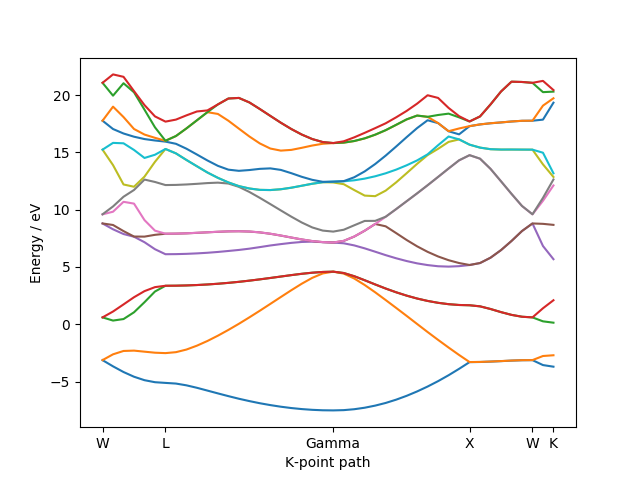

Text(0,0.5,'Energy / eV')

In [83]:
# Plot the band structure
ilbs, lbs = [bs_kpoints.get_attr(s) for s in ('label_numbers', 'labels')]

for eigen in bands_data.T:
    plt.plot(eigen)
plt.xticks(ilbs, lbs)
plt.xlabel("K-point path")
plt.ylabel("Energy / eV")

In [84]:
# Finall we can export the provenanec graph
!verdi graph generate -f png {spec_calc.pk}

Output file is 241.png


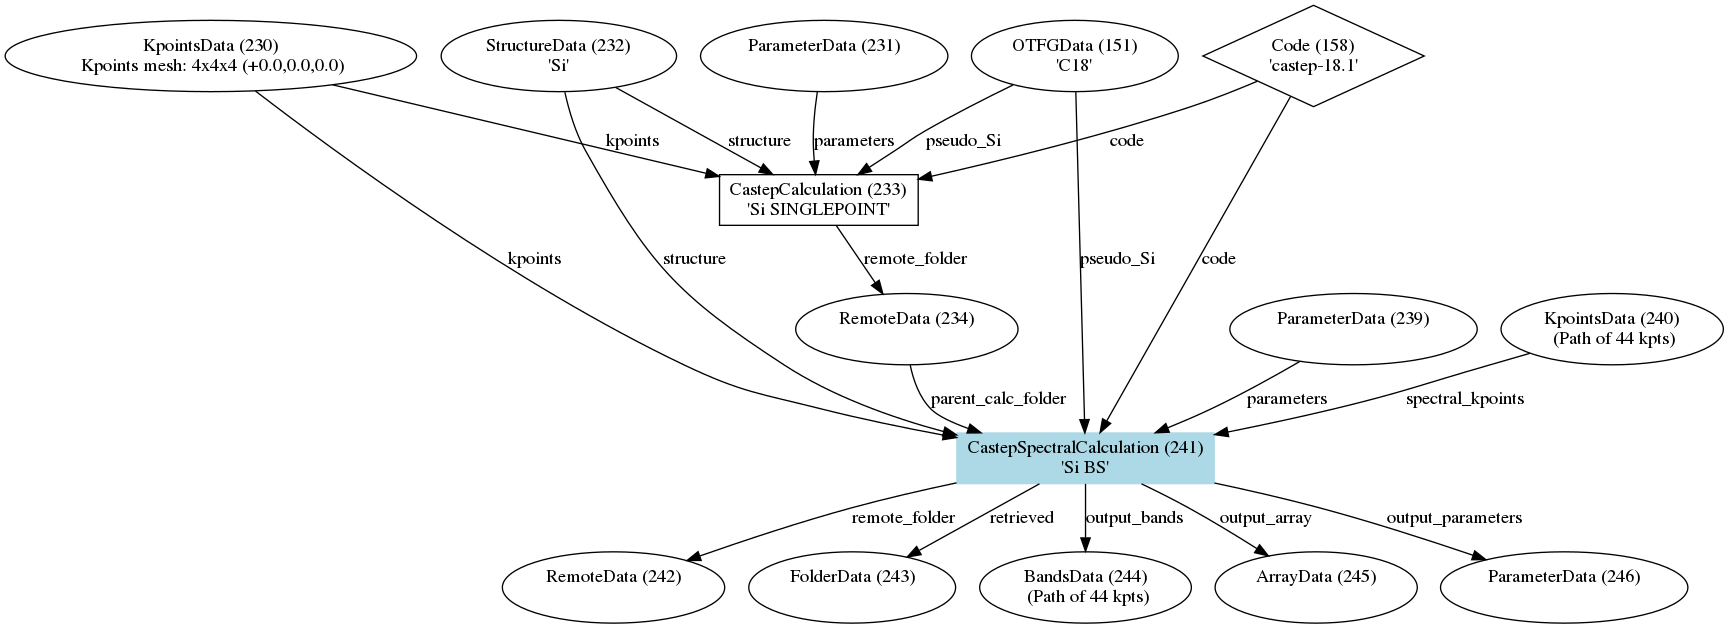

In [85]:
from IPython.display import Image
Image("{}.png".format(spec_calc.pk))